# Deep Learning 2023 - Assignment 4: Generative Adversarial Network (GAN)
Designed by Haotian Liu (haotian.liu@oulu.fi)

## Outline 
#### In this assignment, you will learn:
* Building a Generative Adversarial Network (GAN) in PyTorch.
* Loading the pretrained parameters in PyTorch.
* Training and evaluating your GAN in PyTorch.

#### Tasks (<span style="color:green">15 points</span>)

* **Part 1. Import Libraries, Downloading Dataset and Pretrained Weights**

* **Part 2. Build Your Own Generative Adversarial Network (GAN) (<span style="color:green">8 points</span>)**
  * 2.1 Build the Generator (<span style="color:green">3.5 points</span>)
  * 2.2 Build the Discriminator (<span style="color:green">3.5 points</span>)
  * 2.3 Load the pre-trained weights (<span style="color:green">1 point</span>)

* **Part 3. Train Your GAN on a New Dataset (<span style="color:green">7 points</span>)**
  * 3.1 Prepare the dataset and dataloader
  * 3.2 Implement the training step of Discriminator (<span style="color:green">2 points</span>)
  * 3.3 Implement the training step of Generator (<span style="color:green">2 points</span>)
      * Question (<span style="color:green">1 point</span>)
  * 3.4 Training and evaluate your GAN (<span style="color:green">1 point</span>)
  * Question (<span style="color:green">1 point</span>)

#### Environment
Python 3, Numpy, matplotlib, torch, torchvision

#### Dataset
* [CelebA](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) (CelebFaces Attributes Dataset) is a large-scale face attributes dataset with more than 200K celebrity images, each with 40 attribute annotations. The images in this dataset cover large pose variations and background clutter. In this assignment, we use the CelebA dataset to train a GAN in advance as a pretraining step.

* [AnimeFace](https://www.kaggle.com/datasets/soumikrakshit/anime-faces) is a dataset consisting of 21551 anime faces scraped from an anime website. All images are resized to 64 * 64 for the sake of convenience. In this assignment, we perform transfer learning and treat the AnimeFace dataset as the downstream dataset.

#### Hints
* To find the place where you have to insert your solution, hit Crtl + F and search for **TODO:** . You are NOT supposed to modify the codes from other parts.
* Be careful with the shapes of the tensors through the model.
* Read the instructions in the notebook and links of the official document from PyTorch to understand how to use some modules and functions properly.
* Please compare the intermediate outputs with the reference results and visualizations to check the correctness of your code.

## Part 1. Import Libraries, Downloading Dataset and Pretrained Weights
**You don't need to change the code from this part.**

In [1]:
import argparse
import os
import random

import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms
import torchvision.utils as utils

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import time

try:
    torch.use_deterministic_algorithms(True)
    torch.backends.cudnn.deterministic = True
except:
    pass

The following code will switch to cuda device automatically to accelerate your code if gpu is available in your environment.

To enable GPU in Google Colab, you can navigate to `Edit → Notebook Settings → Hardware Accelerator` , and then select `T4 GPU` or `TPU`.

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# If you encounter some issues regarding cuda device, e.g., "RuntimeError: CUDA Out of memory error",
# try to switch the device to cpu by using the following code

# device = torch.device('cpu')

print('Device:', device)

Device: cpu


### Dataset and Pretrained Weights

Here we use the [onedrivedownloader](https://pypi.org/project/onedrivedownloader/) package for data and pretrained weights downloading.

In [3]:
!pip install onedrivedownloader

In [4]:
from onedrivedownloader import download

link1 = 'https://unioulu-my.sharepoint.com/:u:/g/personal/hliu22_univ_yo_oulu_fi/EQ9E0Sfcne5DghyvYekxvvwBSXJEaE-MMyNep7BkbqWvbA?e=OZNJcF'

link2 = 'https://unioulu-my.sharepoint.com/:u:/g/personal/hliu22_univ_yo_oulu_fi/EXV7Amf7tbxOrFPZvdIdcbcB3lx9tdGo8ccg1NVM6w-gQw?e=IER4ec'

if not os.path.exists('./data_hw4/anime'):
    print('Downloading dataset')
    download(link1, filename='./anime.zip', unzip=True, unzip_path='./data_hw4/anime')

if not os.path.exists('./pretrained'):
    print('Downloading pretrained weights')
    download(link2, filename='./gan_pretrained.zip', unzip=True, unzip_path='./pretrained')

100%|████████████████████████████████████████████████████████████████████████████| 21.5M/21.5M [00:05<00:00, 3.68MiB/s]


Unzipping file...


Extracting files: 100%|███████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 994.28it/s]


100%|████████████████████████████████████████████████████████████████████████████| 2.01M/2.01M [00:00<00:00, 5.66MiB/s]


Unzipping file...


Extracting files: 100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 169.08it/s]


## Part 2. Build Your Own Generative Adversarial Network (GAN)

**Some of the following contents and figures are borrowed from the website [here](https://developers.google.com/machine-learning/gan). You could also check it for more information.**

A [**Generative Adversarial Network (GAN)**](https://en.wikipedia.org/wiki/Generative_adversarial_network) has two parts:

* The **Generator** learns to generate plausible data. The generated instances become negative training examples for the discriminator.

* The **Discriminator** learns to distinguish the Generator's fake data from real data. The Discriminator penalizes the generator for producing implausible results.

When training begins, the generator produces obviously fake data, and the discriminator quickly learns to tell that it's fake. As training progresses, the Generator gets closer to producing output that can fool the discriminator.

<img src="https://developers.google.com/static/machine-learning/gan/images/bad_gan.svg" width="650" style="float: left;">


<img src="https://developers.google.com/static/machine-learning/gan/images/ok_gan.svg" width="650" style="float: left;">

Finally, if generator training goes well, the Discriminator gets worse at telling the difference between real and fake. It starts to classify fake data as real, and its accuracy decreases.

<img src="https://developers.google.com/static/machine-learning/gan/images/good_gan.svg" width="650" style="float: left;">

The whole framework of a Generative Adversarial Network (GAN) can be illustrated as follows:

<img src="https://developers.google.com/static/machine-learning/gan/images/gan_diagram.svg" width="650" style="float: left;">

In the following parts, we will bulid a simple Generator and Discrimnator based on [DCGAN (Deep Convolutional Generative Adversarial Networks)](https://arxiv.org/abs/1511.06434).

### 2.1 Build the Generator (<span style="color:green">3.5 points</span>)

For the Generator, it takes a batch of random noises as inputs and generates an image for each noise vector.
- The random noises have a shape `(B, 100)`. Here `B` is the batch size, and `100` is the dimension of each noise vector. We then convert the shape to `(B, 100, 1, 1)`, i.e., `(batch_size, channels, height, width)`, to make it suitable for convolutional operations.
- As shown in the figure below, our Generator consists of four convolutional layers, it enlarges the resolution of feature maps and obtains the generated images as outputs with a shape `(B, 3, 32, 32)`.

Let's build the Generator based on the following figure.

<img src="http://yty.kapsi.fi/DLcourse/ass4/Generator.png" width="600" style="float: left;">

**Hints:**
1. The Generator class is inherited from [**`nn.Module`**](https://pytorch.org/docs/stable/generated/torch.nn.Module.html), we need to define the model layers in **`__init__()`** and implement the forward pass in **`forward()`**.


2. Here we use some built-in classes in PyTorch, try to check their documents carefully when you encounter some issues.
- `ConvTransposed` denotes [**`nn.ConvTranspose2d()`**](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html), we need to assign the parameters of `in_channels`, `out_channels`, `kernel_size`, `stride`, and `padding`, and use **`bias=False`** in our implementation. Please check the figure carefully and choose the correct value for each layer.

- `BN` denotes [**`nn.BatchNorm2d()`**](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html), we need to assign the correct value for `num_features`.

- `ReLU` denotes [**`nn.ReLU()`**](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) and `Tanh` denotes [**`nn.Tanh()`**](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html). We can use them directly.

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        # TODO: Define each layer of the Generator based on the figure above (3 points)

        # Shapes of each layer: inputs -> outputs, (B, C, H, W)
                
        # conv1: (B, 100, 1, 1) -> (B, 128, 4, 4)
        self.conv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=100, out_channels=, kernel_size=, stride=, padding=, bias=False),
            nn.BatchNorm2d(num_features=),
            nn.ReLU(),
        )

        # conv2: (B, 128, 4, 4) -> (B, 64, 8, 8)
        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(..., bias=False),
            ...
        )

        # conv3: (B, 64, 8, 8) -> (B, 32, 16, 16)
        self.conv3 = nn.Sequential(
            ...
        )

        # conv4: (B, 32, 16, 16) -> (B, 3, 32, 32)
        self.conv4 = nn.Sequential(
            ...
        )

    def forward(self, x):        
        # TODO: Finish the forward-pass by using each defined layer above. (0.5 point)
        
        # Hints: You can also check the shape of intermediate outputs with the following code.
        # print(x.shape)
        
        x = self.conv1(x)
        x = ...
        ...

        return x

In [6]:
# Create the Generator
model_G = Generator().to(device)
print(model_G, '\n')

B = 2
noises = torch.randn((B, 100, 1, 1), device=device)
images = model_G(noises) # It will call the `forward()` function when using `model_G()`.

print('Shape of input:', noises.shape)
print('Shape of output:', images.shape)

Generator(
  (conv1): Sequential(
    (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv3): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv4): Sequential(
    (0): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): Tanh()
  )
) 

Shape of input: torch.Size([2, 100, 1, 1])
Shape of output: torch.Size([2, 3, 32, 32])


**<span style="color:green">Reference Results:</span>** <br>
Generator(<br>
&emsp;(conv1): Sequential(<br>
&emsp;&emsp;(0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)<br>
&emsp;&emsp;(1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)<br>
&emsp;&emsp;(2): ReLU()<br>
&emsp;)<br>
&emsp;(conv2): Sequential(<br>
&emsp;&emsp;(0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)<br>
&emsp;&emsp;(1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)<br>
&emsp;&emsp;(2): ReLU()<br>
&emsp;)<br>
&emsp;(conv3): Sequential(<br>
&emsp;&emsp;(0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)<br>
&emsp;&emsp;(1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)<br>
&emsp;&emsp;(2): ReLU()<br>
&emsp;)<br>
&emsp;(conv4): Sequential(<br>
&emsp;&emsp;(0): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)<br>
&emsp;&emsp;(1): Tanh()<br>
&emsp;)<br>
)<br>
<br>
Shape of input: torch.Size([2, 100, 1, 1]) <br>
Shape of output: torch.Size([2, 3, 32, 32]) <br>

### 2.2 Build the Discriminator (<span style="color:green">3.5 points</span>)

For the Discriminator, it takes a batch of images as inputs and make their classification outputs of real or fake.
- The image inputs have a shape `(B, 3, 32, 32)`, i.e., `(batch_size, channels, height, width)`.
- The classification outpus are with a shape `(B, 1, 1, 1)`, we then flatten it to a vector with a shape `(B, )` to make the loss computation friendly.

The detailed structure of Discriminator is shown as follows:

<img src="http://yty.kapsi.fi/DLcourse/ass4/Discriminator.png" width="600" style="float: left;">

**Hints:**
1. Similar to the Generator, the Discriminator is inherited from [**`nn.Module`**](https://pytorch.org/docs/stable/generated/torch.nn.Module.html), we need to define the model layers in **`__init__()`** and implement the forward pass in **`forward()`**.


2. Here we use some built-in classes in PyTorch, try to check their doucments carefully when you encounter some issues.
- `Conv` denotes [**`nn.Conv2d()`**](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html), we need to assign the parameters of `in_channels`, `out_channels`, `kernel_size`, `stride`, and `padding`, and use **`bias=False`** in our implementation. Please check the figure carefully and choose the correct values for each layer.

- `BN` denotes [**`nn.BatchNorm2d()`**](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html).

- `LeakyReLU` denotes [**`nn.LeakyReLU()`**](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html), we need to use **`negative_slope=0.2`** in our implementation.

- `Sigmoid` denotes [**`nn.Sigmoid()`**](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html).

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        # TODO: Define each layer of the Discriminator based on the figure above (3 points)

        # Shapes of each layer: inputs -> outputs, (B, C, H, W)
                
        # conv1: (B, 3, 32, 32) -> (B, 32, 16, 16)
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=, kernel_size=, stride=, padding=, bias=False),
            nn.LeakyReLU(negative_slope=),
        )

        # conv2: (B, 32, 16, 16) -> (B, 64, 8, 8)
        self.conv2 = nn.Sequential(
            nn.Conv2d(..., bias=False),
            ...
        )

        # conv3: (B, 64, 8, 8) -> (B, 128, 4, 4)
        self.conv3 = nn.Sequential(
            ...
        )

        # conv3: (B, 128, 4, 4) -> (B, 1, 1, 1)
        self.conv4 = nn.Sequential(
            ...
        )

    def forward(self, x):        
        # TODO: Finish the forward-pass by using each defined layer above. (0.5 point)
       
        x = 

        # In the end, we convert the tensor to a vector to make the loss computation friendly
        # flatten: (B, 1, 1, 1) -> (B, )
        x = x.flatten()
        return x

In [8]:
# Create the Discriminator
model_D = Discriminator().to(device)
print(model_D, '\n')

B = 2
images = torch.randn((B, 3, 32, 32), device=device)
outputs = model_D(images) # It will call the `forward()` function when using `model_D()`.

print('Shape of input:', images.shape)
print('Shape of output:', outputs.shape)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): Sigmoid()
  )
) 

Shape of input: torch.Size([2, 3, 32, 32])
Shape of output: torch.Size([2])


**<span style="color:green">Reference Results:</span>** <br>
Discriminator(<br>
&emsp;(conv1): Sequential(<br>
&emsp;&emsp;(0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)<br>
&emsp;&emsp;(1): LeakyReLU(negative_slope=0.2)<br>
&emsp;)<br>
&emsp;(conv2): Sequential(<br>
&emsp;&emsp;(0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)<br>
&emsp;&emsp;(1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)<br>
&emsp;&emsp;(2): LeakyReLU(negative_slope=0.2)<br>
&emsp;)<br>
&emsp;(conv3): Sequential(<br>
&emsp;&emsp;(0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)<br>
&emsp;&emsp;(1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)<br>
&emsp;&emsp;(2): LeakyReLU(negative_slope=0.2)<br>
&emsp;)<br>
&emsp;(conv4): Sequential(<br>
&emsp;&emsp;(0): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)<br>
&emsp;&emsp;(1): Sigmoid()<br>
&emsp;)<br>
)<br>
<br>
Shape of input: torch.Size([2, 3, 32, 32])<br>
Shape of output: torch.Size([2])<br>

### 2.3 Load the pre-trained weights (<span style="color:green">1 point</span>)

Here we will load the pretrained weights of the Generator and Discriminator from the CelebA dataset.

In [9]:
def load_pretrained_weights(model_G, model_D, is_debug=False):
    weights_G_path = 'pretrained/weights_G.pth'
    weights_D_path = 'pretrained/weights_D.pth'

    # TODO: Complete the code to load pretrained weights from local files. (1 point)
    
    # Hints: Call `torch.load()` to load the pretrained weights and pass `weights_G_path` and `weights_D_path` individually.
    weights_G = 
    weights_D = 
    
    # Hints: Call `load_state_dict()` and pass `weights_G` and `weights_D` individually.
    model_G.load_state_dict(...)
    model_D.load_state_dict(...)
    
    if is_debug:
        print('The type of weights_D:\n', type(weights_D), '\n')
        print('The keys in weights_D:\n', list(weights_D.keys()), '\n')
        print('The shape of conv1.0 in weights_D:\n', weights_D['conv1.0.weight'].shape)

If you can run the following code smoothly without any warning or error messages, then the definition of your Generator and Discriminator is correct.

**Otherwise, you should re-check the defination code of Generator and Discriminator above, and make sure your intermediate outputs and the reference results are exactly the same.**

In [10]:
model_G = Generator().to(device)
model_D = Discriminator().to(device)

load_pretrained_weights(model_G, model_D, is_debug=True)

The type of weights_D:
 <class 'collections.OrderedDict'> 

The keys in weights_D:
 ['conv1.0.weight', 'conv2.0.weight', 'conv2.1.weight', 'conv2.1.bias', 'conv2.1.running_mean', 'conv2.1.running_var', 'conv2.1.num_batches_tracked', 'conv3.0.weight', 'conv3.1.weight', 'conv3.1.bias', 'conv3.1.running_mean', 'conv3.1.running_var', 'conv3.1.num_batches_tracked', 'conv4.0.weight'] 

The shape of conv1.0 in weights_D:
 torch.Size([32, 3, 4, 4])


**<span style="color:green">Reference Results:</span>** <br>
The type of weights_D:<br>
 <class 'collections.OrderedDict'> <br>
<br>
The keys in weights_D:<br>
 ['conv1.0.weight', 'conv2.0.weight', 'conv2.1.weight', 'conv2.1.bias', 'conv2.1.running_mean', 'conv2.1.running_var', 'conv2.1.num_batches_tracked', 'conv3.0.weight', 'conv3.1.weight', 'conv3.1.bias', 'conv3.1.running_mean', 'conv3.1.running_var', 'conv3.1.num_batches_tracked', 'conv4.0.weight'] <br>
<br>
The shape of conv1.0 in weights_D:<br>
 torch.Size([32, 3, 4, 4])<br>

From the above outputs, we can also find that the pretrained weights are stored as a `dict`. Its keys contain the name of each layer, and the weights are saved as tensors directly.

Here we can also make a visual comparison between the random initialized and pretrained Generator:

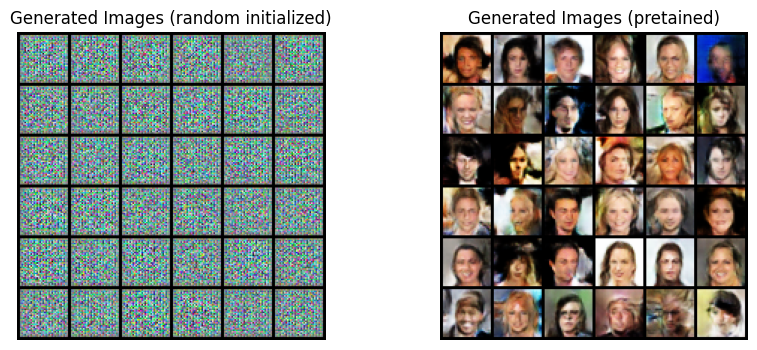

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Create the instances of Generator and Discriminator
model_G = Generator().to(device)
model_D = Discriminator().to(device)

# Create a group of fixed noise vectors for visualization.
fixed_noise = torch.randn((36, 100, 1, 1), device=device)

# Generate images with the random initialized Generator and display them.
generated_images = model_G(fixed_noise)
generated_images = utils.make_grid(generated_images.detach().cpu(), padding=2, normalize=True, nrow=6)

ax[0].axis('off')
ax[0].set_title('Generated Images (random initialized)')
ax[0].imshow(np.transpose(generated_images, (1, 2, 0)))

# Load the pretrained weights of Generator and Discriminator on CelebA dataset.
load_pretrained_weights(model_G, model_D)

# Generate images with the random initialized Generator and display them.
generated_images_pretrained = model_G(fixed_noise)
generated_images_pretrained = utils.make_grid(generated_images_pretrained.detach().cpu(), padding=2, normalize=True, nrow=6)

ax[1].axis('off')
ax[1].set_title('Generated Images (pretained)')
ax[1].imshow(np.transpose(generated_images_pretrained, (1, 2, 0)))

If the pretrained weights are loaded correctly, you can see some faces from the generated images in the right figure. 

## Part 3. Train Your GAN on a New Dataset

### 3.1 Prepare the dataset and dataloader

Define some hyper-parameters for the data preprocessing and training.

In [12]:
# Image Size
image_size = 32

# Batch size during training
batch_size = 128
num_workers = 1

# Learning rate for optimizers
lr = 0.0002

# Number of training epochs
num_epochs = 30

Create the dataset and dataloader to load the AnimeFace dataset for training.

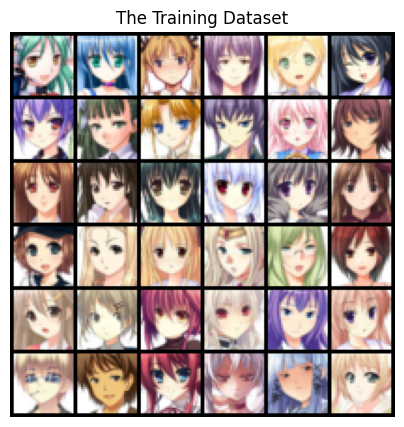

In [13]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = torchvision.datasets.ImageFolder(
    root='./data_hw4',
    transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
)

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(5, 5))
plt.axis('off')
plt.title('The Training Dataset')
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:36], padding=2, normalize=True, nrow=6).cpu(),(1,2,0)))

Here we integrate all the model definition and initialization steps into one function `init_model_and_optimizer()`.

**We choose [`nn.BCELoss()`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) as the loss function.**

In [14]:
def init_model_and_optimizer():

    # Create the instances of Generator and Discriminator
    model_G = Generator().to(device)
    model_D = Discriminator().to(device)

    # Load the pretraind weights of model_G and model_D
    load_pretrained_weights(model_G, model_D)

    # Setup Adam optimizers for both model_G and model_D
    optimizer_G = torch.optim.Adam(model_G.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_D = torch.optim.Adam(model_D.parameters(), lr=lr, betas=(0.5, 0.999))
    
    # Initialize the loss function for training
    BCE_loss = nn.BCELoss()
    
    return model_G, model_D, optimizer_G, optimizer_D, BCE_loss

In [15]:
model_G, model_D, optimizer_G, optimizer_D, BCE_loss = init_model_and_optimizer()

### 3.2 Implement the training step of Discriminator (<span style="color:green">2 points</span>)

The Discriminator's training data comes from two sources:
- Real images, such as real pictures of faces. The Discriminator uses these instances as positive examples during training.
- Fake images are generated by the Generator. The Discriminator uses these instances as negative examples during training.

The training step of the Discriminator is shown in the figure below. During the training step of Discriminator:
- The Discriminator classifies both **real images** and **fake images from the Generator**.
- The Discriminator loss penalizes the Discriminator for misclassifying a real instance as fake or a fake instance as real.
- The Discriminator updates its weights through backpropagation from the discriminator loss through the discriminator network.

<img src="https://developers.google.com/static/machine-learning/gan/images/gan_diagram_discriminator.svg" width="650" style="float: left;">

In [16]:
def training_step_D(
    real_images,
    model_G: nn.Module,
    model_D: nn.Module, 
    optimizer_D: torch.optim.Optimizer,
    BCE_loss: nn.BCELoss,
    is_debug=False,
):
    """Method of the training step for Discriminator.

    Args:
        real_images: a batch of real image data from the training dataset.
        model_G: the Generator model
        model_D: the Discriminator model
        optimizer_D: optimizer of the Discriminator
        BCE_loss: binary cross entropy loss function for loss computation

    Returns:
        loss_D: the Discriminator loss

    """

    # Resets the gradients of all parameters in Discriminator
    model_D.zero_grad()
    
    batch_size = real_images.shape[0]

    # Prepare the real images and their labels
    real_images = real_images.to(device)
    real_labels = torch.ones((batch_size, ), device=device)
    
    # Prepare the fake images and their labels
    noise = torch.randn((batch_size, 100, 1, 1), device=device)
    fake_images = model_G(noise)
    fake_labels = torch.zeros((batch_size, ), device=device)

    
    # TODO: Call `model_D()` and `BCE_loss` to calculate the losses of real and fake images (2 points)
    # Hints: (1) pass `real_images` into `model_D()` to get the `real_outputs`.
    #        (2) calculate the `loss_D_real` with `real_outputs` and `real_labels` using `BCE_loss()`.
    #        (3) calculate the `loss_D_fake` following a similar way as (1)(2).
    real_outputs = model_D(...)
    loss_D_real = BCE_loss(...)

    fake_outputs = 
    loss_D_fake = 

    
    # Sum the loss of both real images and fake images.
    loss_D = loss_D_real + loss_D_fake
    
    # Compute the gradients
    loss_D.backward()
    
    # Update the parameters of `model_D`
    optimizer_D.step()

    if is_debug:
        print('Shape of real outputs:\n', real_outputs.shape, '\n')
        print('Shape and samples of real labels:\n', real_labels.shape, ' ', real_labels[:5], '\n')
        
        print('Shape of fake outputs:\n', fake_outputs.shape, '\n')
        print('Shape and samples of fake labels:\n', fake_labels.shape, ' ', fake_labels[:5], '\n')
    
    return loss_D

In [17]:
torch.manual_seed(0)

batch_data = torch.randn((batch_size, 3, 32, 32), device=device)
model_G, model_D, optimizer_G, optimizer_D, BCE_loss = init_model_and_optimizer()

loss_D = training_step_D(batch_data, model_G, model_D, optimizer_D, BCE_loss, is_debug=True)
print('Discriminator loss:\n', loss_D)

Shape of real outputs:
 torch.Size([128]) 

Shape and samples of real labels:
 torch.Size([128])   tensor([1., 1., 1., 1., 1.]) 

Shape of fake outputs:
 torch.Size([128]) 

Shape and samples of fake labels:
 torch.Size([128])   tensor([0., 0., 0., 0., 0.]) 

Discriminator loss:
 tensor(11.3854, grad_fn=<AddBackward0>)


**<span style="color:green">Reference Results:</span>** <br>
Shape of real outputs:<br>
 torch.Size([128]) <br>
<br>
Shape and samples of real labels:<br>
 torch.Size([128])&emsp;tensor([1., 1., 1., 1., 1.]) <br>
<br>
Shape of fake outputs:<br>
 torch.Size([128]) <br>
<br>
Shape and samples of fake labels:<br>
 torch.Size([128])&emsp;tensor([0., 0., 0., 0., 0.]) <br>
<br>
Discriminator loss:<br>
 tensor(11.3854, grad_fn=\<AddBackward0>)<br><br>
(If you are using GPU, you may get slightly different results for the Discriminator loss, but this is okay)

### 3.3 Implement the training step of Generator (<span style="color:green">2 points</span>)

Generator training requires tighter integration between the generator and the discriminator than discriminator training requires. The portion of the GAN that trains the generator includes:
- random noise inputs
- generator network, which transforms the random input into a data instance
- discriminator network, which classifies the generated data
- discriminator output
- generator loss, which penalizes the generator for failing to fool the discriminator

To train a neural net, we alter the net's weights to reduce the error or loss of its output. In our GAN, however, the generator is not directly connected to the loss that we're trying to affect. The generator feeds into the discriminator net, and the discriminator produces the output we're trying to affect. This training step is shown in the figure below.

**The generator loss penalizes the generator for producing an image that the discriminator network classifies as fake. In other words, we wish the generated images could be classified as real by the discriminator in this training step.**

<img src="https://developers.google.com/static/machine-learning/gan/images/gan_diagram_generator.svg" width="650" style="float: left;">

In [18]:
def training_step_G(
    model_G: nn.Module,
    model_D: nn.Module,
    optimizer_G: torch.optim.Optimizer,
    BCE_loss: nn.BCELoss,
    is_debug=False,
):
    """Method of the training step for Generator.

    Args:
        model_G: the Generator model
        model_D: the Discriminator model
        optimizer_G: optimizer of the Generator
        BCE_loss: binary cross entropy loss function for loss computation

    Returns:
        loss_G: the Generator loss
    
    """

    # Reset the gradients of all parameters in `model_G`.
    model_G.zero_grad()
    
    # Generate fake images from `model_G` with random noises.
    noise = torch.randn((batch_size, 100, 1, 1), device=device)
    fake_images = model_G(noise)

    
    # TODO: Prepare labels for fake_images (1 point)
    # Hints: create the labels for the training of Generator, consider carefully which line of code below is correct.

    # labels = torch.zeros((batch_size, ), device=device)
    # labels = torch.ones((batch_size, ), device=device)
    
    
    # TODO: Call `model_D()` and `BCE_loss` to calculate the loss of Generator (1 point)
    # Hints: (1) pass `fake_images` into `model_D()` to get the `outputs`.
    #        (2) calculate the `loss_G` with `outputs` and `labels` using `BCE_loss()`.
    outputs = 
    loss_G = 

    
    # Compute the gradients
    loss_G.backward()
    
    # Update the parameters of `model_G`
    optimizer_G.step()

    if is_debug:
        print('Shape of outputs:\n', outputs.shape, '\n')
        print('Shape of labels:\n', labels.shape, '\n')

    return loss_G

In [19]:
torch.manual_seed(0)

model_G, model_D, optimizer_G, optimizer_D, BCE_loss = init_model_and_optimizer()

loss_G = training_step_G(model_G, model_D, optimizer_G, BCE_loss, is_debug=True)

Shape of outputs:
 torch.Size([128]) 

Shape of labels:
 torch.Size([128]) 



**<span style="color:green">Reference Results:</span>** <br>
Shape of outputs:<br>
 torch.Size([128]) <br>
<br>
Shape of labels:<br>
 torch.Size([128]) <br>

### Question: In this training step, why the real images are not used for training? (<span style="color:green">1 point</span>)

**Your Answer: (TODO)**

### 3.4 Training and evaluate your GAN  (<span style="color:green">1 point</span>)

In [20]:
# Create the model, optimizer, and loss functions for training

model_G, model_D, optimizer_G, optimizer_D, BCE_loss = init_model_and_optimizer()


# Lists and variables to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

torch.random.seed()
start_time = time.time()


# Training Loop

print("Starting Training Loop...")

for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (real_images, _) in enumerate(dataloader, 0):

        # TODO: call the `training_step_D()` and `training_step_G()` and collect the loss values `loss_D` and `loss_G` (1 point)
        # Hints: pass variables required by these two functions, including:
        #        `real_images`, `model_G`, `model_D`, `optimizer_D`, `optimizer_G`, and `BCE_loss`.
        loss_D = 
        loss_G = 

        
        # Output training stats
        if i % 50 == 0:
            print('[Epoch][Iter][{}/{}][{}/{}] Loss_D: {:.4f}, Loss_G: {:.4f}, Time: {:.2f} s'.format(
                epoch, num_epochs, i, len(dataloader), loss_D.item(), loss_G.item(), time.time() - start_time))
            start_time = time.time()

        # Save Losses for plotting later
        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 50 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = model_G(fixed_noise).detach().cpu()
            img_list.append(utils.make_grid(fake, padding=2, normalize=True, nrow=6))
        iters += 1

Starting Training Loop...
[Epoch][Iter][0/30][0/16] Loss_D: 1.8396, Loss_G: 0.9450, Time: 3.06 s
[Epoch][Iter][1/30][0/16] Loss_D: 0.0887, Loss_G: 3.7554, Time: 8.00 s
[Epoch][Iter][2/30][0/16] Loss_D: 0.2294, Loss_G: 3.8162, Time: 7.86 s
[Epoch][Iter][3/30][0/16] Loss_D: 0.0789, Loss_G: 4.2464, Time: 9.12 s
[Epoch][Iter][4/30][0/16] Loss_D: 0.1282, Loss_G: 4.8443, Time: 7.53 s
[Epoch][Iter][5/30][0/16] Loss_D: 0.1871, Loss_G: 3.5489, Time: 7.41 s
[Epoch][Iter][6/30][0/16] Loss_D: 0.3786, Loss_G: 1.6024, Time: 7.61 s
[Epoch][Iter][7/30][0/16] Loss_D: 0.5075, Loss_G: 4.1866, Time: 7.42 s
[Epoch][Iter][8/30][0/16] Loss_D: 0.3181, Loss_G: 3.4217, Time: 7.32 s
[Epoch][Iter][9/30][0/16] Loss_D: 1.3632, Loss_G: 0.8538, Time: 7.68 s
[Epoch][Iter][10/30][0/16] Loss_D: 0.3755, Loss_G: 2.8511, Time: 7.57 s
[Epoch][Iter][11/30][0/16] Loss_D: 0.3619, Loss_G: 2.2157, Time: 7.26 s
[Epoch][Iter][12/30][0/16] Loss_D: 0.4370, Loss_G: 3.0618, Time: 7.56 s
[Epoch][Iter][13/30][0/16] Loss_D: 0.4352, Loss_

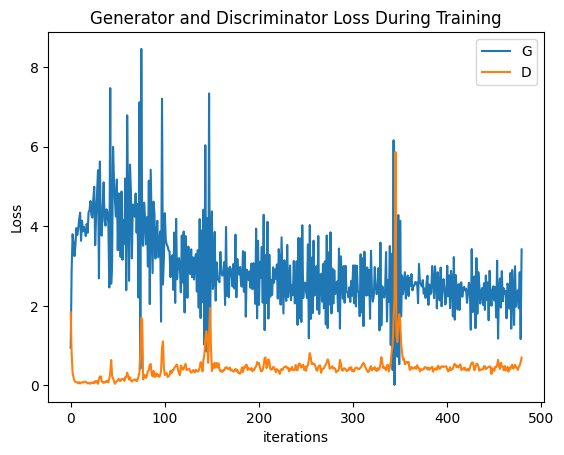

In [21]:
plt.figure()
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

We can visualize the generated images from at the end of training:

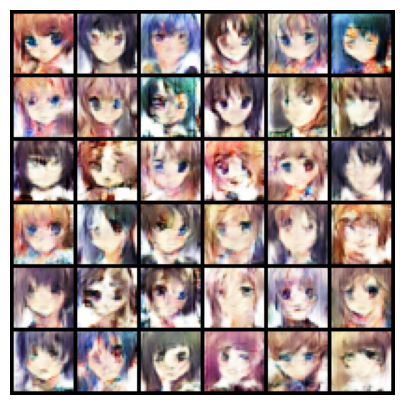

In [22]:
fig = plt.figure(figsize=(5, 5))
plt.axis("off")

ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]

**Hints: If you can't get any expected outputs similar to images in the AnimeFace dataset, try to debug your code of `training_step_G()` and `training_step_D()` again.**

We can also visualize how the generated images from fixed noises change during training:

In [ ]:
ani = animation.ArtistAnimation(fig, ims, interval=300, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

### Question: How to improve the quality of generated images? Pose your idea or introduce an recent image generative model with better performances. (<span style="color:green">1 point</span>)

**Your Answer: (TODO)**